In [1]:
trial_number_ml = "009"
random_state_init = 999

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 18:02:19,281] A new study created in memory with name: no-name-3e03c433-07f5-478d-97e8-a1f0c386f3f1


[I 2024-05-01 18:02:45,310] Trial 2 finished with value: 0.7127860908786151 and parameters: {'n_estimators': 141, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 2 with value: 0.7127860908786151.


[I 2024-05-01 18:03:49,187] Trial 0 finished with value: 0.720750413961946 and parameters: {'n_estimators': 440, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.720750413961946.


[I 2024-05-01 18:04:11,819] Trial 3 finished with value: 0.7239386828391187 and parameters: {'n_estimators': 657, 'max_depth': 67, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 3 with value: 0.7239386828391187.


[I 2024-05-01 18:04:20,958] Trial 1 finished with value: 0.7341378925019556 and parameters: {'n_estimators': 503, 'max_depth': 63, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7341378925019556.


[I 2024-05-01 18:05:42,965] Trial 4 finished with value: 0.7280793181564217 and parameters: {'n_estimators': 856, 'max_depth': 89, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7341378925019556.


[I 2024-05-01 18:06:09,618] Trial 8 finished with value: 0.7306321681447393 and parameters: {'n_estimators': 134, 'max_depth': 29, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7341378925019556.


[I 2024-05-01 18:06:21,184] Trial 9 pruned. 


[I 2024-05-01 18:06:21,796] Trial 5 finished with value: 0.7268039090197991 and parameters: {'n_estimators': 808, 'max_depth': 67, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7341378925019556.


[I 2024-05-01 18:06:33,077] Trial 7 finished with value: 0.7319040217799856 and parameters: {'n_estimators': 676, 'max_depth': 85, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7341378925019556.


[I 2024-05-01 18:07:03,001] Trial 6 finished with value: 0.741785268034011 and parameters: {'n_estimators': 825, 'max_depth': 91, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.741785268034011.


[I 2024-05-01 18:07:37,259] Trial 12 finished with value: 0.7242515669602495 and parameters: {'n_estimators': 389, 'max_depth': 70, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.741785268034011.


[I 2024-05-01 18:07:45,134] Trial 11 finished with value: 0.7382810674630989 and parameters: {'n_estimators': 509, 'max_depth': 55, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 6 with value: 0.741785268034011.


[I 2024-05-01 18:08:31,637] Trial 10 finished with value: 0.7312691108198985 and parameters: {'n_estimators': 859, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 6 with value: 0.741785268034011.


[I 2024-05-01 18:10:07,995] Trial 13 finished with value: 0.7395564765997217 and parameters: {'n_estimators': 988, 'max_depth': 97, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 6 with value: 0.741785268034011.


[I 2024-05-01 18:10:26,640] Trial 15 finished with value: 0.7370071821127805 and parameters: {'n_estimators': 989, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 6 with value: 0.741785268034011.


[I 2024-05-01 18:10:39,090] Trial 14 finished with value: 0.7354122857810421 and parameters: {'n_estimators': 995, 'max_depth': 98, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.741785268034011.


[I 2024-05-01 18:11:20,552] Trial 16 finished with value: 0.7417872997490831 and parameters: {'n_estimators': 994, 'max_depth': 99, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:12:47,368] Trial 19 finished with value: 0.7395569845284897 and parameters: {'n_estimators': 740, 'max_depth': 82, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:13:06,956] Trial 17 finished with value: 0.7363682077225489 and parameters: {'n_estimators': 992, 'max_depth': 99, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:13:14,186] Trial 18 finished with value: 0.7379620881967514 and parameters: {'n_estimators': 955, 'max_depth': 98, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:13:29,498] Trial 20 finished with value: 0.7395559686709536 and parameters: {'n_estimators': 775, 'max_depth': 80, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:13:43,161] Trial 22 pruned. 


[I 2024-05-01 18:15:28,147] Trial 21 finished with value: 0.7405123985412285 and parameters: {'n_estimators': 894, 'max_depth': 77, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:15:36,686] Trial 23 finished with value: 0.7373220979489836 and parameters: {'n_estimators': 616, 'max_depth': 77, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:15:37,553] Trial 24 finished with value: 0.7386005546582147 and parameters: {'n_estimators': 695, 'max_depth': 78, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:15:56,936] Trial 25 finished with value: 0.7414683204827355 and parameters: {'n_estimators': 690, 'max_depth': 87, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:17:22,526] Trial 26 finished with value: 0.7344568717683032 and parameters: {'n_estimators': 627, 'max_depth': 88, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:17:45,324] Trial 29 finished with value: 0.7341358607868832 and parameters: {'n_estimators': 606, 'max_depth': 89, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:17:50,980] Trial 30 pruned. 


[I 2024-05-01 18:18:11,919] Trial 28 finished with value: 0.7366856632025925 and parameters: {'n_estimators': 875, 'max_depth': 90, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:18:14,620] Trial 27 finished with value: 0.7360487205274332 and parameters: {'n_estimators': 895, 'max_depth': 90, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:18:18,810] Trial 31 pruned. 


[I 2024-05-01 18:18:19,583] Trial 32 pruned. 


[I 2024-05-01 18:18:40,971] Trial 33 pruned. 


[I 2024-05-01 18:18:47,244] Trial 36 pruned. 


[I 2024-05-01 18:19:50,125] Trial 34 finished with value: 0.7370066741840123 and parameters: {'n_estimators': 778, 'max_depth': 71, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:19:56,982] Trial 39 pruned. 


[I 2024-05-01 18:20:07,807] Trial 40 pruned. 


[I 2024-05-01 18:20:09,767] Trial 35 finished with value: 0.7350943223722306 and parameters: {'n_estimators': 932, 'max_depth': 73, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:20:22,971] Trial 38 finished with value: 0.7373241296640559 and parameters: {'n_estimators': 805, 'max_depth': 73, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:20:30,172] Trial 37 finished with value: 0.7373236217352878 and parameters: {'n_estimators': 910, 'max_depth': 73, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:20:34,355] Trial 41 pruned. 


[I 2024-05-01 18:20:35,971] Trial 42 pruned. 


[I 2024-05-01 18:20:46,080] Trial 43 pruned. 


[I 2024-05-01 18:20:51,867] Trial 44 pruned. 


[I 2024-05-01 18:20:53,992] Trial 46 pruned. 


[I 2024-05-01 18:20:56,427] Trial 45 pruned. 


[I 2024-05-01 18:21:07,163] Trial 49 pruned. 


[I 2024-05-01 18:21:29,339] Trial 47 finished with value: 0.7417837442477067 and parameters: {'n_estimators': 655, 'max_depth': 83, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


[I 2024-05-01 18:21:31,155] Trial 48 finished with value: 0.7389185180670264 and parameters: {'n_estimators': 697, 'max_depth': 65, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 16 with value: 0.7417872997490831.


Best trial for RandomForestClassifier:
  Value: 0.7417872997490831
  Params: 
    n_estimators: 994
    max_depth: 99
    min_samples_split: 9
    min_samples_leaf: 2
    max_features: log2

Best hyperparameters for RandomForestClassifier: {'n_estimators': 994, 'max_depth': 99, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}


[I 2024-05-01 18:21:44,279] A new study created in memory with name: no-name-dff99f6c-bc06-4e73-8cea-d04c374b3e41


RandomForestClassifier accuracy: 0.7299



[I 2024-05-01 18:21:49,400] Trial 2 finished with value: 0.7290352400979285 and parameters: {'n_estimators': 180, 'max_depth': 9, 'learning_rate': 0.19630542413427846, 'min_child_weight': 2, 'subsample': 0.9715437541877884, 'colsample_bytree': 0.5929547512429365, 'gamma': 1.7151483670566585, 'reg_lambda': 0.8140123292716324, 'reg_alpha': 0.5147738894852868}. Best is trial 2 with value: 0.7290352400979285.


[I 2024-05-01 18:21:51,020] Trial 0 finished with value: 0.7210668535844533 and parameters: {'n_estimators': 235, 'max_depth': 7, 'learning_rate': 0.2614415681100863, 'min_child_weight': 4, 'subsample': 0.6536920277037133, 'colsample_bytree': 0.612383105338755, 'gamma': 2.591786065031325, 'reg_lambda': 6.9328438954160605, 'reg_alpha': 0.12973522680585264}. Best is trial 2 with value: 0.7290352400979285.


[I 2024-05-01 18:22:03,574] Trial 4 finished with value: 0.7274383120511179 and parameters: {'n_estimators': 590, 'max_depth': 3, 'learning_rate': 0.02688835234029019, 'min_child_weight': 6, 'subsample': 0.8517727793070391, 'colsample_bytree': 0.9994495878567635, 'gamma': 1.1749596367487747, 'reg_lambda': 6.087428604586374, 'reg_alpha': 0.28424169082559}. Best is trial 2 with value: 0.7290352400979285.


[I 2024-05-01 18:22:07,959] Trial 1 finished with value: 0.7360497363849694 and parameters: {'n_estimators': 855, 'max_depth': 10, 'learning_rate': 0.026687082536916436, 'min_child_weight': 7, 'subsample': 0.9633578226840966, 'colsample_bytree': 0.8534916765333405, 'gamma': 0.4568057150377658, 'reg_lambda': 0.032625708914730094, 'reg_alpha': 5.426536199564491}. Best is trial 1 with value: 0.7360497363849694.


[I 2024-05-01 18:22:12,465] Trial 5 finished with value: 0.7271203486423065 and parameters: {'n_estimators': 908, 'max_depth': 7, 'learning_rate': 0.18182735984563395, 'min_child_weight': 9, 'subsample': 0.880373753299383, 'colsample_bytree': 0.895065363703715, 'gamma': 3.9906339172516905, 'reg_lambda': 8.931137010364399, 'reg_alpha': 0.2861950317445128}. Best is trial 1 with value: 0.7360497363849694.


[I 2024-05-01 18:22:13,126] Trial 7 pruned. 


[I 2024-05-01 18:22:13,665] Trial 3 pruned. 


[I 2024-05-01 18:22:15,111] Trial 6 pruned. 


[I 2024-05-01 18:22:19,373] Trial 10 pruned. 


[I 2024-05-01 18:22:21,086] Trial 12 pruned. 


[I 2024-05-01 18:22:23,850] Trial 9 pruned. 


[I 2024-05-01 18:22:24,991] Trial 13 pruned. 


[I 2024-05-01 18:22:26,504] Trial 15 pruned. 


[I 2024-05-01 18:22:26,851] Trial 14 pruned. 


[I 2024-05-01 18:22:37,851] Trial 8 finished with value: 0.7328594357927244 and parameters: {'n_estimators': 615, 'max_depth': 5, 'learning_rate': 0.05074039433423707, 'min_child_weight': 5, 'subsample': 0.6267846664807144, 'colsample_bytree': 0.6800931566960524, 'gamma': 3.606844042175959, 'reg_lambda': 0.0177789280991856, 'reg_alpha': 2.264501504428365}. Best is trial 1 with value: 0.7360497363849694.


[I 2024-05-01 18:22:41,318] Trial 11 finished with value: 0.7274510102703197 and parameters: {'n_estimators': 428, 'max_depth': 5, 'learning_rate': 0.08264927380719078, 'min_child_weight': 10, 'subsample': 0.9342212198343416, 'colsample_bytree': 0.8530388009755259, 'gamma': 0.3041642670517375, 'reg_lambda': 0.053707704206094345, 'reg_alpha': 0.010917704839021271}. Best is trial 1 with value: 0.7360497363849694.


[I 2024-05-01 18:22:43,354] Trial 18 pruned. 


[I 2024-05-01 18:22:44,037] Trial 17 finished with value: 0.736361604648564 and parameters: {'n_estimators': 194, 'max_depth': 9, 'learning_rate': 0.06803137894443695, 'min_child_weight': 3, 'subsample': 0.8145585649224938, 'colsample_bytree': 0.673090349640634, 'gamma': 0.6315133002358799, 'reg_lambda': 0.03917401703690059, 'reg_alpha': 1.158673505807174}. Best is trial 17 with value: 0.736361604648564.


[I 2024-05-01 18:22:45,978] Trial 16 finished with value: 0.7312625077459136 and parameters: {'n_estimators': 222, 'max_depth': 9, 'learning_rate': 0.0883225367114413, 'min_child_weight': 1, 'subsample': 0.8316521431043911, 'colsample_bytree': 0.8355692300800219, 'gamma': 0.6575125587492235, 'reg_lambda': 0.6754570986448095, 'reg_alpha': 1.8413171810303488}. Best is trial 17 with value: 0.736361604648564.


[I 2024-05-01 18:22:49,922] Trial 20 pruned. 


[I 2024-05-01 18:22:51,894] Trial 19 pruned. 


[I 2024-05-01 18:23:03,783] Trial 21 finished with value: 0.7350851796544052 and parameters: {'n_estimators': 239, 'max_depth': 8, 'learning_rate': 0.03694798635774531, 'min_child_weight': 3, 'subsample': 0.8475812297382932, 'colsample_bytree': 0.8032095957842784, 'gamma': 0.7622915648276458, 'reg_lambda': 0.030124082503200283, 'reg_alpha': 0.8849549516260802}. Best is trial 17 with value: 0.736361604648564.


[I 2024-05-01 18:23:06,692] Trial 22 finished with value: 0.7360416095246802 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.03794744043105723, 'min_child_weight': 3, 'subsample': 0.8032064799118259, 'colsample_bytree': 0.7845540138097518, 'gamma': 0.751636587432359, 'reg_lambda': 0.029659415291653, 'reg_alpha': 0.7855276180943108}. Best is trial 17 with value: 0.736361604648564.


[I 2024-05-01 18:23:11,689] Trial 26 pruned. 


[I 2024-05-01 18:23:15,574] Trial 23 finished with value: 0.7322214772600291 and parameters: {'n_estimators': 260, 'max_depth': 8, 'learning_rate': 0.01670251766825523, 'min_child_weight': 3, 'subsample': 0.7861576045653265, 'colsample_bytree': 0.7826681496534229, 'gamma': 0.8964666709135153, 'reg_lambda': 0.3020687732933939, 'reg_alpha': 0.5862668829057549}. Best is trial 17 with value: 0.736361604648564.


[I 2024-05-01 18:23:17,292] Trial 27 pruned. 


[I 2024-05-01 18:23:22,481] Trial 29 pruned. 


[I 2024-05-01 18:23:29,798] Trial 24 finished with value: 0.7373226058777517 and parameters: {'n_estimators': 435, 'max_depth': 8, 'learning_rate': 0.012703519405863213, 'min_child_weight': 3, 'subsample': 0.7644282109589222, 'colsample_bytree': 0.6514354120836444, 'gamma': 0.537419738715103, 'reg_lambda': 0.0239270483765042, 'reg_alpha': 0.8676708346651335}. Best is trial 24 with value: 0.7373226058777517.


[I 2024-05-01 18:23:30,212] Trial 25 finished with value: 0.7334928229665072 and parameters: {'n_estimators': 261, 'max_depth': 8, 'learning_rate': 0.016042335714744185, 'min_child_weight': 3, 'subsample': 0.773104887901819, 'colsample_bytree': 0.9205313713470531, 'gamma': 0.6921178032996894, 'reg_lambda': 0.2615584219168103, 'reg_alpha': 0.7900603749803378}. Best is trial 24 with value: 0.7373226058777517.


[I 2024-05-01 18:23:34,492] Trial 28 finished with value: 0.7398729162222291 and parameters: {'n_estimators': 379, 'max_depth': 10, 'learning_rate': 0.09748207181233975, 'min_child_weight': 4, 'subsample': 0.8881808723016753, 'colsample_bytree': 0.9052956985009318, 'gamma': 1.5078082130817458, 'reg_lambda': 0.06777123065441118, 'reg_alpha': 4.055064606689403}. Best is trial 28 with value: 0.7398729162222291.


[I 2024-05-01 18:23:38,001] Trial 31 pruned. 


[I 2024-05-01 18:23:41,351] Trial 32 pruned. 


[I 2024-05-01 18:23:42,179] Trial 34 pruned. 


[I 2024-05-01 18:23:42,787] Trial 30 finished with value: 0.733177399201536 and parameters: {'n_estimators': 179, 'max_depth': 9, 'learning_rate': 0.0696265424369326, 'min_child_weight': 4, 'subsample': 0.8757689413571603, 'colsample_bytree': 0.8885521322963681, 'gamma': 0.44643368232065633, 'reg_lambda': 0.12491085137662884, 'reg_alpha': 0.05530240949158866}. Best is trial 28 with value: 0.7398729162222291.


[I 2024-05-01 18:23:45,113] Trial 36 pruned. 


[I 2024-05-01 18:23:46,721] Trial 37 pruned. 


[I 2024-05-01 18:23:48,060] Trial 35 pruned. 


[I 2024-05-01 18:23:51,719] Trial 38 pruned. 


[I 2024-05-01 18:23:55,389] Trial 41 pruned. 


[I 2024-05-01 18:24:00,667] Trial 40 pruned. 


[I 2024-05-01 18:24:02,970] Trial 42 pruned. 


[I 2024-05-01 18:24:06,510] Trial 43 pruned. 


[I 2024-05-01 18:24:06,980] Trial 33 finished with value: 0.7223392151484676 and parameters: {'n_estimators': 487, 'max_depth': 7, 'learning_rate': 0.06710852679240728, 'min_child_weight': 4, 'subsample': 0.6828108631842987, 'colsample_bytree': 0.5481816621756531, 'gamma': 2.3824258484415832, 'reg_lambda': 0.09422873160602606, 'reg_alpha': 0.045012530137127894}. Best is trial 28 with value: 0.7398729162222291.


[I 2024-05-01 18:24:10,455] Trial 39 pruned. 


[I 2024-05-01 18:24:19,262] Trial 46 pruned. 


[I 2024-05-01 18:24:21,515] Trial 48 pruned. 


[I 2024-05-01 18:24:22,148] Trial 44 finished with value: 0.7354092382084336 and parameters: {'n_estimators': 196, 'max_depth': 8, 'learning_rate': 0.04511649387648462, 'min_child_weight': 4, 'subsample': 0.7287502612641645, 'colsample_bytree': 0.7670607870411841, 'gamma': 1.419945278932012, 'reg_lambda': 0.02714401002093171, 'reg_alpha': 2.8538433435434296}. Best is trial 28 with value: 0.7398729162222291.


[I 2024-05-01 18:24:23,706] Trial 47 finished with value: 0.7331779071303041 and parameters: {'n_estimators': 196, 'max_depth': 8, 'learning_rate': 0.044812832613363114, 'min_child_weight': 3, 'subsample': 0.9686505276715419, 'colsample_bytree': 0.763373527808686, 'gamma': 1.3438002044793673, 'reg_lambda': 0.19624801084746296, 'reg_alpha': 2.8103307315879302}. Best is trial 28 with value: 0.7398729162222291.


[I 2024-05-01 18:24:23,909] Trial 49 pruned. 


[I 2024-05-01 18:24:26,152] Trial 45 pruned. 


Best trial for XGBClassifier:
  Value: 0.7398729162222291
  Params: 
    n_estimators: 379
    max_depth: 10
    learning_rate: 0.09748207181233975
    min_child_weight: 4
    subsample: 0.8881808723016753
    colsample_bytree: 0.9052956985009318
    gamma: 1.5078082130817458
    reg_lambda: 0.06777123065441118
    reg_alpha: 4.055064606689403

Best hyperparameters for XGBClassifier: {'n_estimators': 379, 'max_depth': 10, 'learning_rate': 0.09748207181233975, 'min_child_weight': 4, 'subsample': 0.8881808723016753, 'colsample_bytree': 0.9052956985009318, 'gamma': 1.5078082130817458, 'reg_lambda': 0.06777123065441118, 'reg_alpha': 4.055064606689403}


[I 2024-05-01 18:25:18,295] A new study created in memory with name: no-name-fa8fd638-f746-486e-b20d-61a9e5cf3dff


XGBClassifier accuracy: 0.7236



[I 2024-05-01 18:25:19,291] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 13, 'learning_rate': 0.24104213204812538, 'n_estimators': 584, 'min_child_weight': 0.03671360121337347, 'min_child_samples': 1883, 'subsample': 0.98262209214257, 'colsample_bytree': 0.9176600200883417, 'reg_alpha': 0.000974792138174785, 'reg_lambda': 0.01782455707492547}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 18:25:19,422] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 67, 'max_depth': 9, 'learning_rate': 0.4326357289305121, 'n_estimators': 822, 'min_child_weight': 0.014774563956456366, 'min_child_samples': 1720, 'subsample': 0.9522405126442532, 'colsample_bytree': 0.91258439323502, 'reg_alpha': 0.0002371780996410502, 'reg_lambda': 5.8860744768695275e-08}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 18:25:19,491] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 95, 'max_depth': 9, 'learning_rate': 0.45077973759039003, 'n_estimators': 998, 'min_child_weight': 0.04232446980326548, 'min_child_samples': 1902, 'subsample': 0.8579302643313487, 'colsample_bytree': 0.8770339166542378, 'reg_alpha': 8.00729305467846e-06, 'reg_lambda': 2.3882281041096485e-08}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 18:25:20,280] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 96, 'max_depth': 8, 'learning_rate': 0.42098408703918544, 'n_estimators': 925, 'min_child_weight': 0.0013187011680563597, 'min_child_samples': 1933, 'subsample': 0.9872788620936337, 'colsample_bytree': 0.9185621830964222, 'reg_alpha': 7.307468513281622e-10, 'reg_lambda': 1.7035833817162064e-09}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 18:25:22,695] Trial 4 finished with value: 0.6439206005749754 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'max_depth': 7, 'learning_rate': 0.006263244150622247, 'n_estimators': 239, 'min_child_weight': 0.016700323395781865, 'min_child_samples': 477, 'subsample': 0.9545262994632994, 'colsample_bytree': 0.9190680497610335, 'reg_alpha': 0.00048023334927805667, 'reg_lambda': 0.23753328718660688}. Best is trial 4 with value: 0.6439206005749754.


[I 2024-05-01 18:25:22,998] Trial 2 finished with value: 0.7229766657523948 and parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'max_depth': 5, 'learning_rate': 0.10434894354434908, 'n_estimators': 189, 'min_child_weight': 0.050985820009437105, 'min_child_samples': 95, 'subsample': 0.8525483403762006, 'colsample_bytree': 0.9281657057091784, 'reg_alpha': 5.736557496020016e-08, 'reg_lambda': 8.688467030348521e-10}. Best is trial 2 with value: 0.7229766657523948.


[I 2024-05-01 18:25:25,549] Trial 8 finished with value: 0.6334074909334715 and parameters: {'boosting_type': 'goss', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.16694942093762935, 'n_estimators': 742, 'min_child_weight': 0.08205204929128308, 'min_child_samples': 699, 'subsample': 0.863008413329443, 'colsample_bytree': 0.9495286891346246, 'reg_alpha': 0.0004412459332204818, 'reg_lambda': 1.76163470838576e-05}. Best is trial 2 with value: 0.7229766657523948.


[I 2024-05-01 18:25:26,025] Trial 9 finished with value: 0.6885512855677121 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 6, 'learning_rate': 0.059438481168413895, 'n_estimators': 386, 'min_child_weight': 0.04029538653139583, 'min_child_samples': 481, 'subsample': 0.9913125925811603, 'colsample_bytree': 0.8774653318424698, 'reg_alpha': 0.017842636319813667, 'reg_lambda': 1.5691709606410566e-08}. Best is trial 2 with value: 0.7229766657523948.


[I 2024-05-01 18:25:26,108] Trial 10 pruned. 


[I 2024-05-01 18:25:26,151] Trial 11 pruned. 


[I 2024-05-01 18:25:27,758] Trial 12 finished with value: 0.6468071597639147 and parameters: {'boosting_type': 'goss', 'num_leaves': 45, 'max_depth': 3, 'learning_rate': 0.3636548544813084, 'n_estimators': 342, 'min_child_weight': 0.0027994563076161496, 'min_child_samples': 473, 'subsample': 0.9160209706642608, 'colsample_bytree': 0.8600415352962401, 'reg_alpha': 2.369764567511706e-07, 'reg_lambda': 8.078589786999253e-08}. Best is trial 2 with value: 0.7229766657523948.


[I 2024-05-01 18:25:28,098] Trial 6 pruned. 


[I 2024-05-01 18:25:28,726] Trial 13 finished with value: 0.7175560499395564 and parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'max_depth': 0, 'learning_rate': 0.1343213431286461, 'n_estimators': 101, 'min_child_weight': 0.004403378570207691, 'min_child_samples': 156, 'subsample': 0.8056796542805141, 'colsample_bytree': 0.8293527006448153, 'reg_alpha': 1.1906816580521533e-10, 'reg_lambda': 1.8835203554460658e-10}. Best is trial 2 with value: 0.7229766657523948.


[I 2024-05-01 18:25:32,717] Trial 15 finished with value: 0.7201134712867867 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'max_depth': -1, 'learning_rate': 0.10745590375965457, 'n_estimators': 110, 'min_child_weight': 0.03483157014402998, 'min_child_samples': 50, 'subsample': 0.8059063272957945, 'colsample_bytree': 0.8164015638409077, 'reg_alpha': 0.4695319746516484, 'reg_lambda': 1.9994296822937924e-10}. Best is trial 2 with value: 0.7229766657523948.


[I 2024-05-01 18:25:35,595] Trial 16 finished with value: 0.7350948303009985 and parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'max_depth': -1, 'learning_rate': 0.13094833047148008, 'n_estimators': 111, 'min_child_weight': 0.005329948162418487, 'min_child_samples': 67, 'subsample': 0.8015250641679361, 'colsample_bytree': 0.8043142523407388, 'reg_alpha': 1.2055575202246028e-10, 'reg_lambda': 1.0435129359267969e-10}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:36,445] Trial 18 pruned. 


[I 2024-05-01 18:25:39,281] Trial 7 finished with value: 0.6783556314062515 and parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'max_depth': -1, 'learning_rate': 0.1535246093973302, 'n_estimators': 671, 'min_child_weight': 0.00771299983139814, 'min_child_samples': 687, 'subsample': 0.9757183328163412, 'colsample_bytree': 0.838103373466674, 'reg_alpha': 0.0018347958501062109, 'reg_lambda': 7.173066487615387e-08}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:41,408] Trial 14 finished with value: 0.7201043285689616 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': -1, 'learning_rate': 0.11625644765728034, 'n_estimators': 133, 'min_child_weight': 0.02984357950546086, 'min_child_samples': 24, 'subsample': 0.8189268715062099, 'colsample_bytree': 0.8154085839973948, 'reg_alpha': 0.6019532548191409, 'reg_lambda': 1.1016313701605258e-10}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:42,389] Trial 20 finished with value: 0.6809018783205844 and parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'max_depth': 2, 'learning_rate': 0.07148891598131255, 'n_estimators': 204, 'min_child_weight': 0.0024807033371849205, 'min_child_samples': 224, 'subsample': 0.8373269304524739, 'colsample_bytree': 0.8008144058710838, 'reg_alpha': 7.980914858881305e-09, 'reg_lambda': 0.0009064475967420538}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:42,584] Trial 22 pruned. 


[I 2024-05-01 18:25:44,845] Trial 21 pruned. 


[I 2024-05-01 18:25:44,995] Trial 23 pruned. 


[I 2024-05-01 18:25:46,776] Trial 24 finished with value: 0.6917446337325653 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'max_depth': 1, 'learning_rate': 0.09853940475829998, 'n_estimators': 184, 'min_child_weight': 0.05774979865739744, 'min_child_samples': 58, 'subsample': 0.801667867181226, 'colsample_bytree': 0.8461262341518605, 'reg_alpha': 1.7765745888882963e-05, 'reg_lambda': 1.1492037477625572e-09}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:47,058] Trial 25 finished with value: 0.7073619195644003 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': 1, 'learning_rate': 0.2974087449930368, 'n_estimators': 174, 'min_child_weight': 0.06168826104254115, 'min_child_samples': 44, 'subsample': 0.8022086643940136, 'colsample_bytree': 0.8037646234235553, 'reg_alpha': 8.126379334573533e-06, 'reg_lambda': 1.6313647515190838e-09}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:48,199] Trial 27 finished with value: 0.6968356037749265 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 4, 'learning_rate': 0.1926764684756366, 'n_estimators': 105, 'min_child_weight': 0.026082631644989803, 'min_child_samples': 328, 'subsample': 0.8350033870374521, 'colsample_bytree': 0.8188445702342397, 'reg_alpha': 1.6165369247449266e-07, 'reg_lambda': 1.1799679894466906e-10}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:48,987] Trial 28 pruned. 


[I 2024-05-01 18:25:49,080] Trial 26 finished with value: 0.6901395788254654 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 0, 'learning_rate': 0.3273914016598846, 'n_estimators': 281, 'min_child_weight': 0.023336121401243005, 'min_child_samples': 363, 'subsample': 0.8338568357927519, 'colsample_bytree': 0.801783834426126, 'reg_alpha': 9.948923247965057e-06, 'reg_lambda': 7.906257219183698e-10}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:49,396] Trial 30 pruned. 


[I 2024-05-01 18:25:49,638] Trial 29 pruned. 


[I 2024-05-01 18:25:50,227] Trial 19 finished with value: 0.6965196720811874 and parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'max_depth': 3, 'learning_rate': 0.07639521067917207, 'n_estimators': 502, 'min_child_weight': 0.002161143336045481, 'min_child_samples': 197, 'subsample': 0.8328471305990537, 'colsample_bytree': 0.8393787309135361, 'reg_alpha': 9.532728110298138e-09, 'reg_lambda': 0.0005860067342696078}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:50,273] Trial 17 finished with value: 0.7178785847072806 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'max_depth': -1, 'learning_rate': 0.12437268008247637, 'n_estimators': 113, 'min_child_weight': 0.021576325544540146, 'min_child_samples': 22, 'subsample': 0.8005005424569788, 'colsample_bytree': 0.8196456406053962, 'reg_alpha': 3.908086783867427e-09, 'reg_lambda': 1.0375318745116618e-10}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:51,045] Trial 33 pruned. 


[I 2024-05-01 18:25:53,700] Trial 34 finished with value: 0.711813407287762 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': -1, 'learning_rate': 0.21406503432122642, 'n_estimators': 160, 'min_child_weight': 0.03148367321174069, 'min_child_samples': 157, 'subsample': 0.8141819831317129, 'colsample_bytree': 0.8140262727676754, 'reg_alpha': 0.42850719991206854, 'reg_lambda': 4.3202779715106235e-10}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:55,076] Trial 35 finished with value: 0.7044834872357502 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'max_depth': 0, 'learning_rate': 0.14094844219424224, 'n_estimators': 150, 'min_child_weight': 0.033553566585596835, 'min_child_samples': 141, 'subsample': 0.8469102018919488, 'colsample_bytree': 0.8175735505149345, 'reg_alpha': 0.4369283365190835, 'reg_lambda': 7.0811096124122025e-09}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:55,646] Trial 37 pruned. 


[I 2024-05-01 18:25:56,365] Trial 38 pruned. 


[I 2024-05-01 18:25:58,292] Trial 31 finished with value: 0.7108630725627039 and parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'max_depth': 11, 'learning_rate': 0.13412561924013686, 'n_estimators': 293, 'min_child_weight': 0.00579683828937552, 'min_child_samples': 193, 'subsample': 0.824068481991575, 'colsample_bytree': 0.8985835940127699, 'reg_alpha': 3.99435195692027e-08, 'reg_lambda': 3.626770678584879e-10}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:58,458] Trial 36 finished with value: 0.719793476162903 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 0, 'learning_rate': 0.1585073300216863, 'n_estimators': 138, 'min_child_weight': 0.02932560936323047, 'min_child_samples': 121, 'subsample': 0.848339692892575, 'colsample_bytree': 0.8547311242129533, 'reg_alpha': 0.08669698204949901, 'reg_lambda': 7.762236260387605e-09}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:25:58,602] Trial 40 pruned. 


[I 2024-05-01 18:25:58,828] Trial 41 pruned. 


[I 2024-05-01 18:26:01,531] Trial 32 finished with value: 0.7028987494793729 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 11, 'learning_rate': 0.22086107599759652, 'n_estimators': 613, 'min_child_weight': 0.04632856639113336, 'min_child_samples': 165, 'subsample': 0.8152593052277081, 'colsample_bytree': 0.8638788010201136, 'reg_alpha': 1.2032609308131177e-06, 'reg_lambda': 4.236994110676837e-10}. Best is trial 16 with value: 0.7350948303009985.


[I 2024-05-01 18:26:02,240] Trial 43 pruned. 


[I 2024-05-01 18:26:05,913] Trial 39 finished with value: 0.7354127937098103 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 0, 'learning_rate': 0.028636286075235648, 'n_estimators': 315, 'min_child_weight': 0.030375853318352675, 'min_child_samples': 91, 'subsample': 0.9342994190102342, 'colsample_bytree': 0.8341388223465455, 'reg_alpha': 0.8289928985673222, 'reg_lambda': 6.437531878861251e-10}. Best is trial 39 with value: 0.7354127937098103.


[I 2024-05-01 18:26:08,162] Trial 45 finished with value: 0.6977935574315058 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': -1, 'learning_rate': 0.47722195484482854, 'n_estimators': 203, 'min_child_weight': 0.030842881674439354, 'min_child_samples': 72, 'subsample': 0.854443174168393, 'colsample_bytree': 0.8293413476729729, 'reg_alpha': 0.07563025645837623, 'reg_lambda': 3.5755939817092476e-09}. Best is trial 39 with value: 0.7354127937098103.


[I 2024-05-01 18:26:08,707] Trial 47 pruned. 


[I 2024-05-01 18:26:09,252] Trial 48 pruned. 


[I 2024-05-01 18:26:09,332] Trial 44 finished with value: 0.7233012322351913 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': -1, 'learning_rate': 0.09670187755368513, 'n_estimators': 200, 'min_child_weight': 0.03089950121423953, 'min_child_samples': 58, 'subsample': 0.8655480078971224, 'colsample_bytree': 0.829473413978456, 'reg_alpha': 0.9634672145878106, 'reg_lambda': 2.2613584817546254e-09}. Best is trial 39 with value: 0.7354127937098103.


[I 2024-05-01 18:26:09,435] Trial 49 pruned. 


[I 2024-05-01 18:26:13,109] Trial 46 finished with value: 0.7009843659525188 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'max_depth': -1, 'learning_rate': 0.4794864247576261, 'n_estimators': 215, 'min_child_weight': 0.06815198536674426, 'min_child_samples': 28, 'subsample': 0.9648398029646214, 'colsample_bytree': 0.829038487557187, 'reg_alpha': 0.9195686556157737, 'reg_lambda': 2.808250599335098e-09}. Best is trial 39 with value: 0.7354127937098103.


[I 2024-05-01 18:27:17,012] Trial 42 finished with value: 0.7283993132803055 and parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'max_depth': 7, 'learning_rate': 0.026216780876349557, 'n_estimators': 904, 'min_child_weight': 0.0396687837318271, 'min_child_samples': 24, 'subsample': 0.8088511100477634, 'colsample_bytree': 0.80839850124508, 'reg_alpha': 0.005602395336908883, 'reg_lambda': 2.7020640460420116e-09}. Best is trial 39 with value: 0.7354127937098103.


Best trial for LGBMClassifier:
  Value: 0.7354127937098103
  Params: 
    boosting_type: gbdt
    num_leaves: 70
    max_depth: 0
    learning_rate: 0.028636286075235648
    n_estimators: 315
    min_child_weight: 0.030375853318352675
    min_child_samples: 91
    subsample: 0.9342994190102342
    colsample_bytree: 0.8341388223465455
    reg_alpha: 0.8289928985673222
    reg_lambda: 6.437531878861251e-10

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 0, 'learning_rate': 0.028636286075235648, 'n_estimators': 315, 'min_child_weight': 0.030375853318352675, 'min_child_samples': 91, 'subsample': 0.9342994190102342, 'colsample_bytree': 0.8341388223465455, 'reg_alpha': 0.8289928985673222, 'reg_lambda': 6.437531878861251e-10}


LGBMClassifier accuracy: 0.7338
LGBMClassifier accuracy: 0.7338



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_009/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

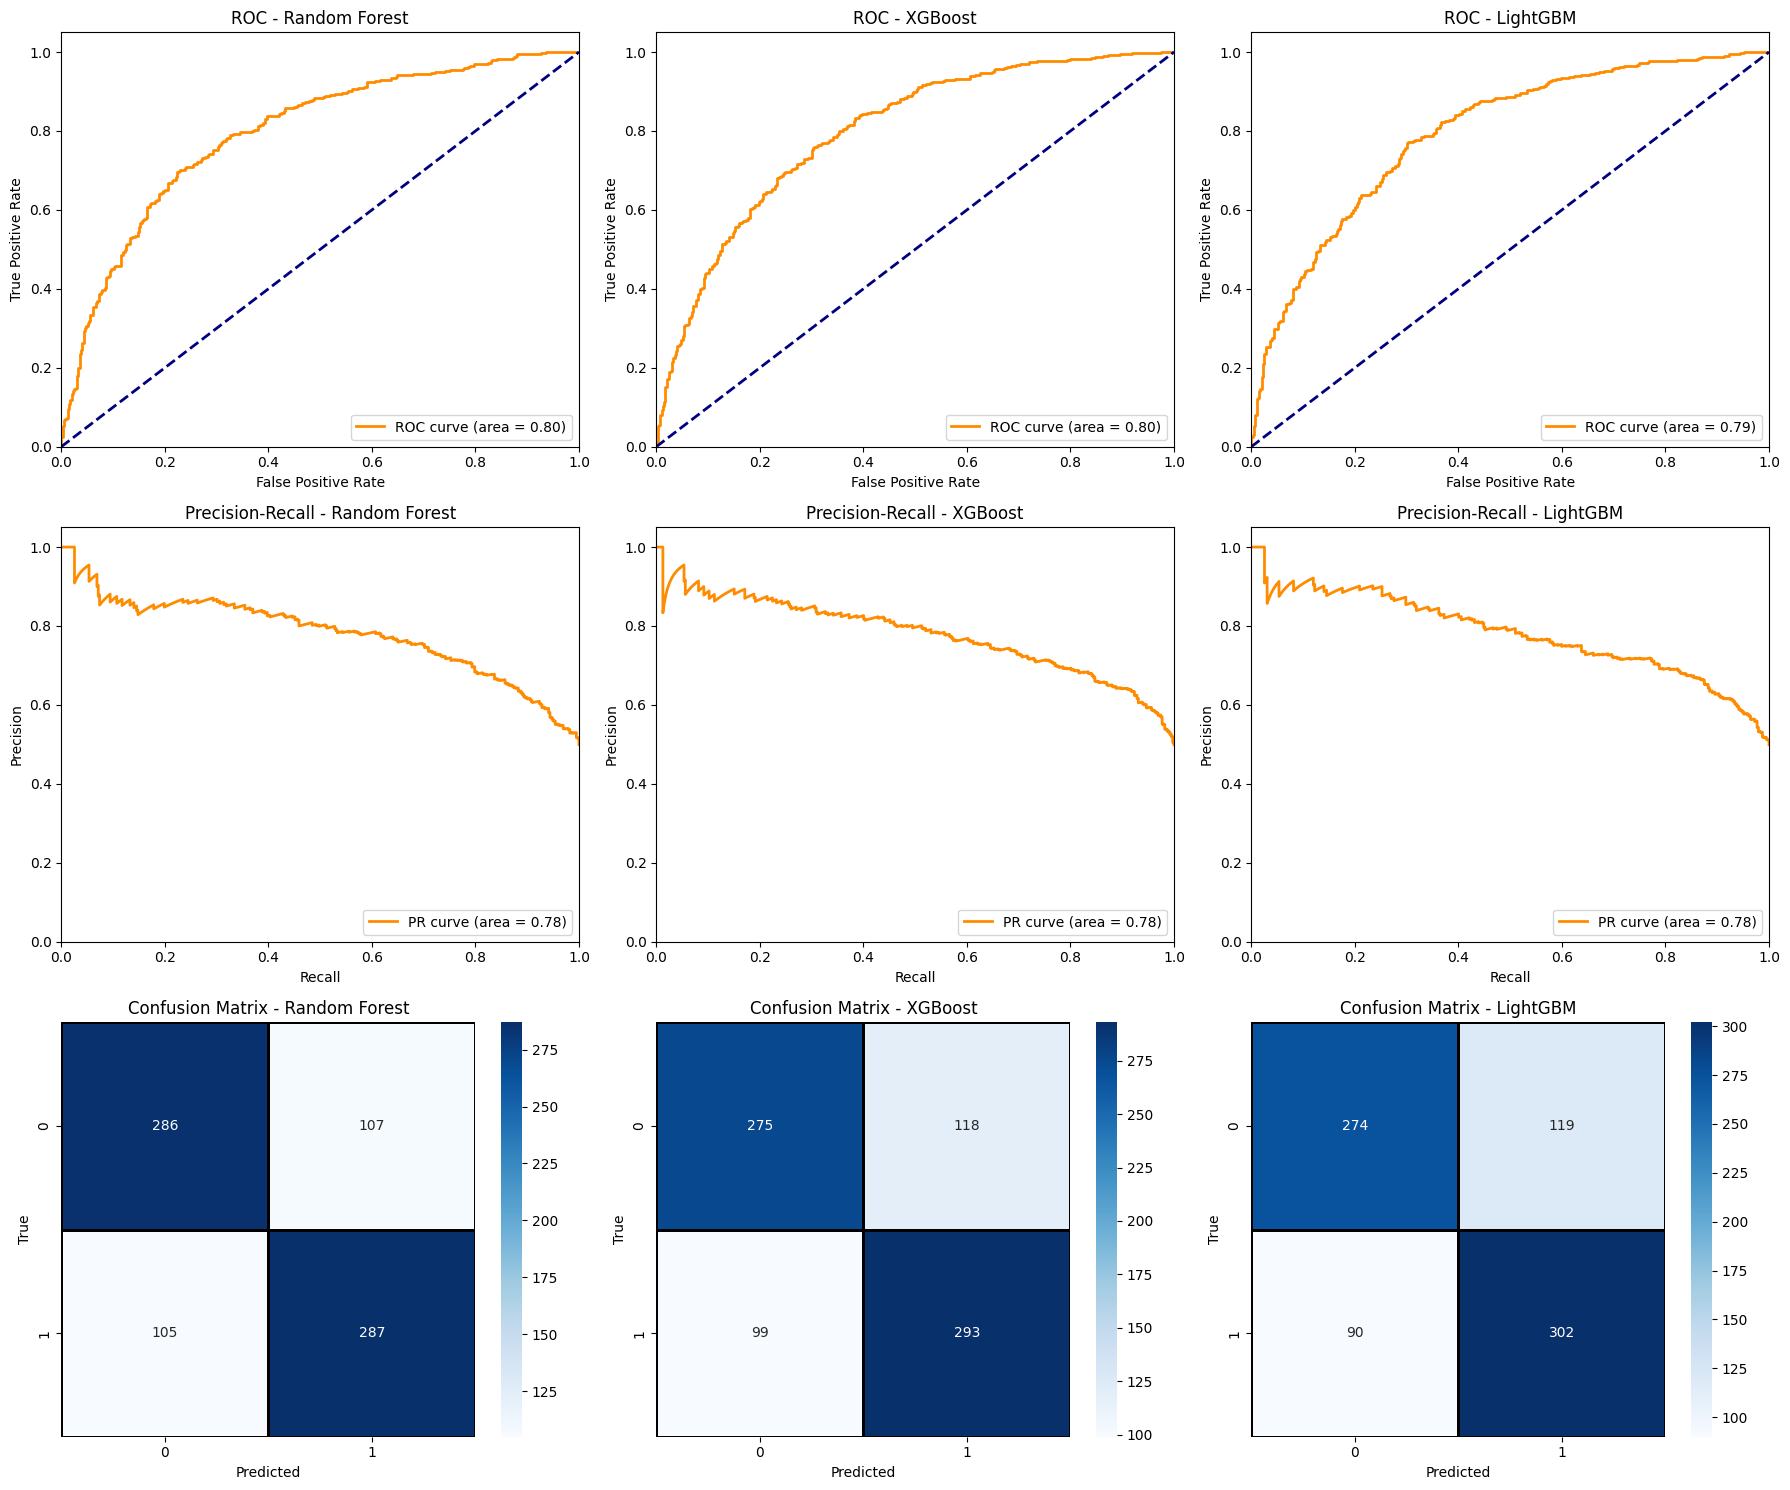

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.729936305732484, 'Precision': 0.7284263959390863, 'Recall': 0.7321428571428571, 'F1 Score': 0.7302798982188294, 'ROC AUC': 0.7954834605597965}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7235668789808917, 'Precision': 0.7128953771289538, 'Recall': 0.7474489795918368, 'F1 Score': 0.7297633872976339, 'ROC AUC': 0.7979046580464247}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.7337579617834394, 'Precision': 0.7173396674584323, 'Recall': 0.7704081632653061, 'F1 Score': 0.7429274292742927, 'ROC AUC': 0.7944903152100535}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.7337579617834394,
 'Precision': 0.7173396674584323,
 'Recall': 0.7704081632653061,
 'F1 Score': 0.7429274292742927,
 'ROC AUC': 0.7944903152100535}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: LightGBM with Accuracy: 0.7338


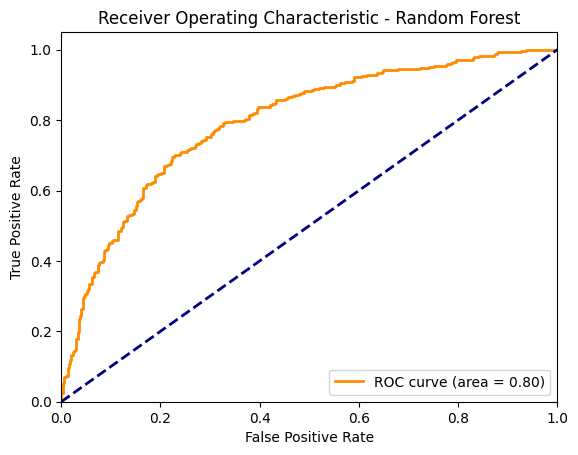

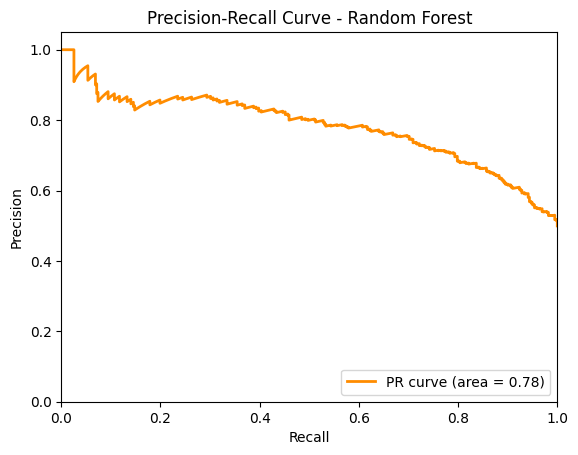

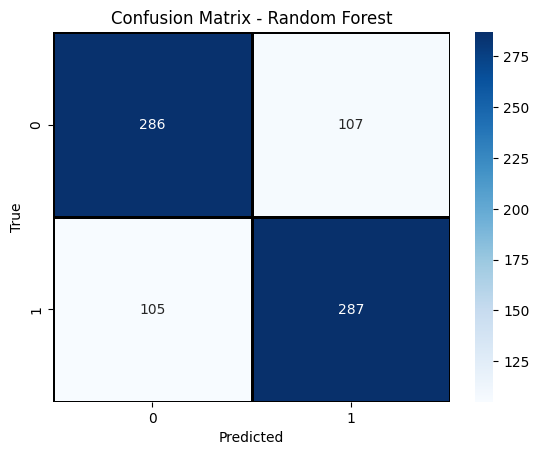

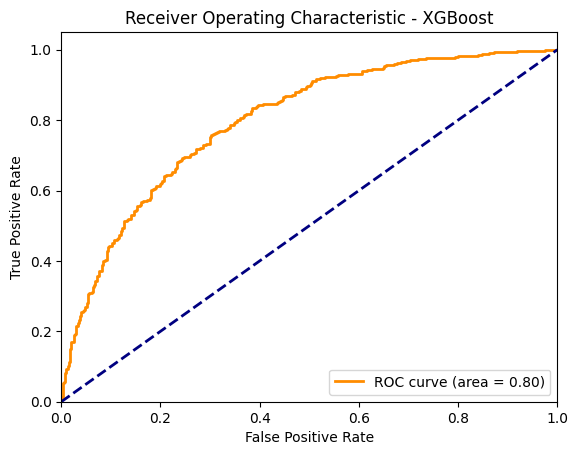

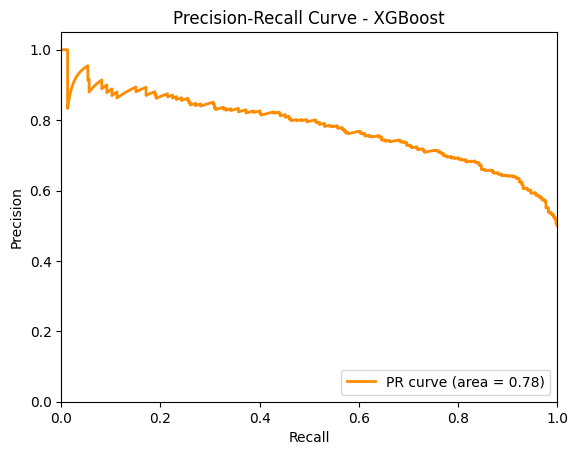

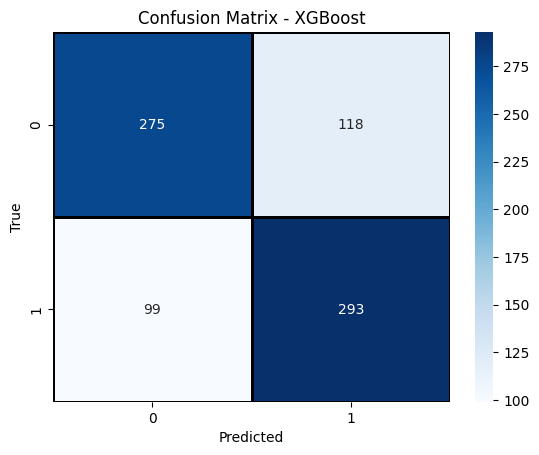

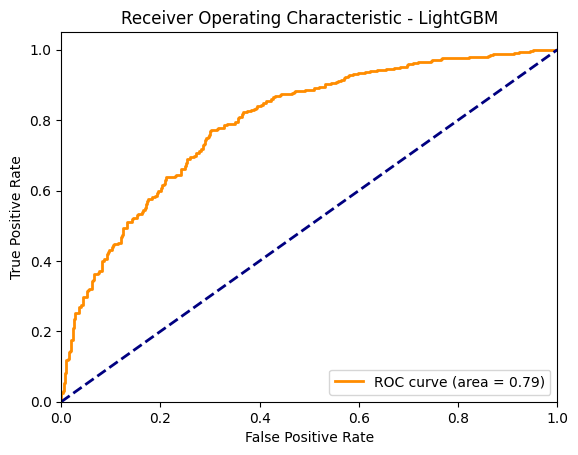

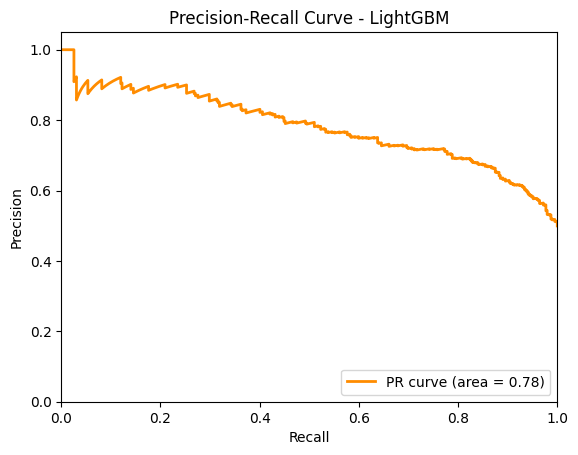

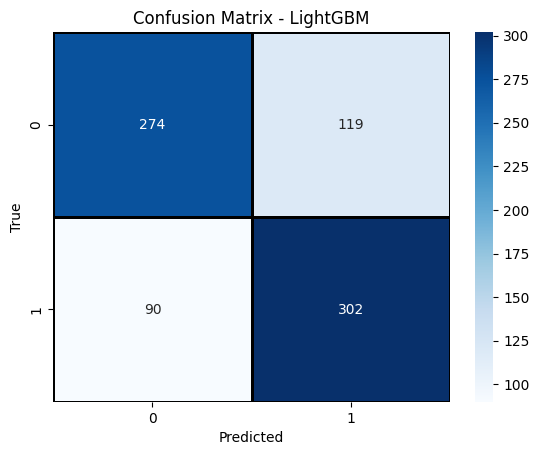

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

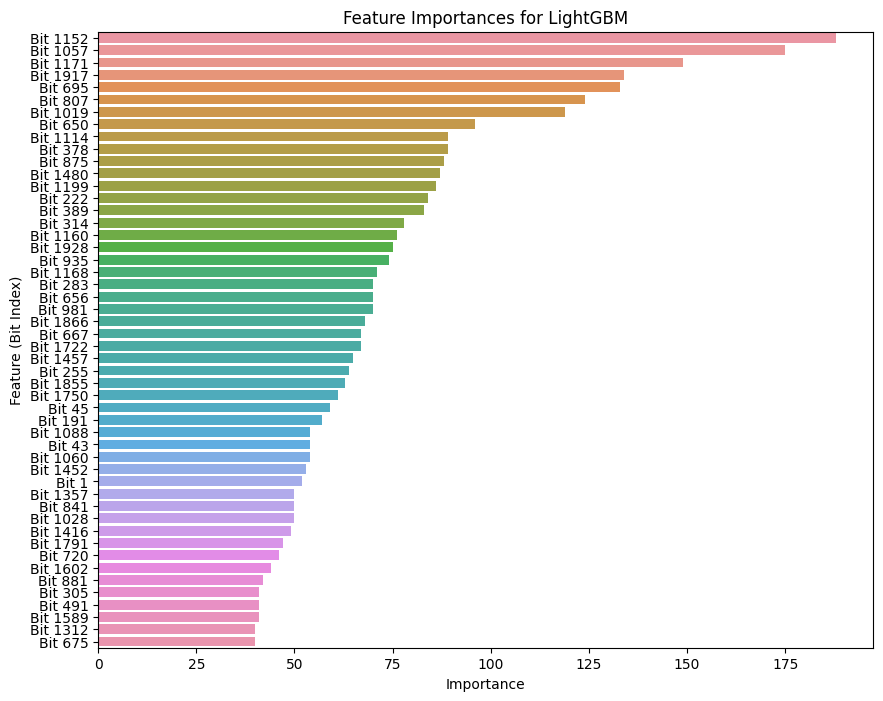

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
